# BERT Prediction Error Analysis

This code is used to:
- Verify the impact from text preprocessing on BERT.
- Utilize the unsupervised learning to look for the patterns of error data

In order to speed up the issue analysis, only 1% of total training data(random sampling) is used.

### Coding for Chapter 4.2.3.4 - Additional error analysis

In [1]:
import warnings
# Disable 3 types of warning
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=(FutureWarning))
warnings.filterwarnings("ignore",category=(RuntimeWarning))

In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
import os
from tqdm import trange
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, precision_recall_fscore_support
from transformers import AdamW,get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification,DistilBertForSequenceClassification
from transformers import BertTokenizer,DistilBertTokenizer
from sklearn.metrics import classification_report, precision_recall_fscore_support
from text_preprocessing import preprocess_text
from text_preprocessing import check_spelling,remove_stopword,lemmatize_word

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\patri\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
# Import helper functions

from helper import train_dev_test, convert_examples_to_inputs,get_data_loader,data_evaluation,duple_labels,elbow_plot,train

In [4]:
#Enable GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Enable logging.
import logging

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

##### Import dataset

In [6]:
import pandas as pd
# load train data
source_train_data_path="./01_data/WikiLarge_Train.csv"
source_train_data=pd.read_csv(source_train_data_path)

RANDOM_STATE=1
PORTION=0.01
size=round(len(source_train_data)*PORTION)
train_data=source_train_data.sample(n=size,random_state=RANDOM_STATE)

Text(0.5, 0, 'length')

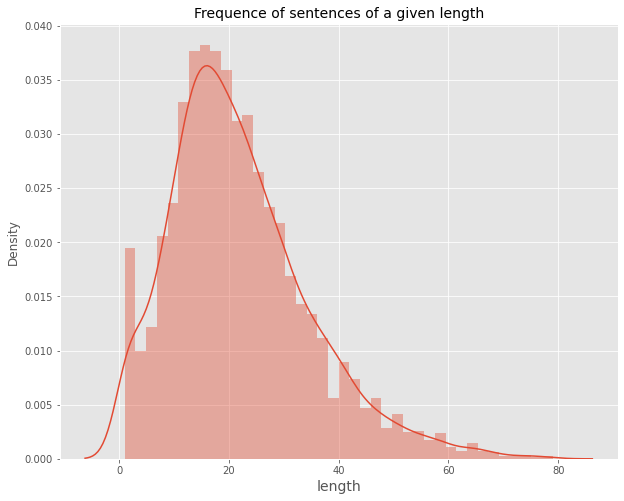

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot histogram with the length. Truncate max length to 5000 tokens.
plt.style.use("ggplot")

plt.figure(figsize=(10, 8))
train_data['length'] = train_data['original_text'].apply(lambda x: len(x.split()))
sns.distplot(train_data[train_data['length'] < 5000]['length'])
plt.title('Frequence of sentences of a given length', fontsize=14)
plt.xlabel('length', fontsize=14)

In [8]:
# BERT token length should not be more than 512.
data_describe=train_data['original_text'].apply(lambda x: len(x.split())).describe()
print(data_describe)
MAX_SEQ_LENGTH=int(data_describe['max'])
if MAX_SEQ_LENGTH>512:
    MAX_SEQ_LENGTH=512

count    4168.000000
mean       21.913628
std        12.775337
min         1.000000
25%        13.000000
50%        20.000000
75%        29.000000
max        79.000000
Name: original_text, dtype: float64


#### Verify the impact from text preprocessing

The following situations will be considered respectively:
- Initial status - Pretrain: evaluate the test dataset without training.
- Fine tune without preprocessing: train the bert, then evaluate the test dataset.
- Remove stopwords,train the bert, then evaluate the test dataset.
- Correct mis-spelling,train the bert, then evaluate the test dataset.
- Lemmanization,train the bert, then evaluate the test dataset.
- Remove duplicate records (same label),train the bert, then evaluate the test dataset.
- Remove duplicated records ( different label),train the bert, then evaluate the test dataset.


In [9]:
# Initalize the parameters for training / evaluation
params={
        "GRADIENT_ACCUMULATION_STEPS":1,
        "NUM_TRAIN_EPOCHS":8,
        "LEARNING_RATE":2e-5,
        "WARMUP_PROPORTION":0.1,
        "MAX_GRAD_NORM":5,
        "MAX_SEQ_LENGTH":MAX_SEQ_LENGTH,
        "BATCH_SIZE":16,
        "NUM_WARMUP_STEPS":600
}
BERT_MODEL = "distilbert-base-uncased"
OUTPUT_DIR = "./tmp/"
MODEL_FILE_NAME = "pytorch_model.bin"

In [10]:
df_acc=pd.DataFrame(columns=['description','accuracy','texts','labels','prediction'])
list_acc=['Pretrain','Fine tune without preprocessing',
                       'Removal of stopwords','Correction of spelling',
                      'Lemmatization','Removal of duplicate records with same labels',
                      'Removal of duplicate records with different labels']

In [11]:
for i in range(len(list_acc)):
    ### prepare for data based on different situation
    process_data=train_data.copy()
    if list_acc[i]=='Removal of stopwords':
        process_data['original_text'] = process_data['original_text'].apply(lambda x:' '.join(remove_stopword(x)))  
    
    if list_acc[i]=='Removal of stopwords':
        process_data['original_text'] = process_data['original_text'].apply(lambda x:' '.join(check_spelling(x)) if type(x)=='str' else x) 

    if list_acc[i]=='Correction of spelling':
        process_data['original_text'] = process_data['original_text'].apply(lambda x:' '.join(remove_stopword(x)))      
       
    if list_acc[i]=='Removal of duplicate records with same labels':
        process_data.drop_duplicates(subset=['original_text','label'],inplace=True)

    if list_acc[i]=='Removal of duplicate records with different labels':
        # look for the records with different labels 
        df_2labels=process_data.copy()
        df_duple_labels=duple_labels(df_2labels)
        # Indentify double labels in data
        df_2labels['duplicated']=df_2labels.duplicated(subset=['original_text'])
        df_2labels=df_2labels.merge(df_duple_labels,how="left",left_on="original_text",right_on="original_text")
        df_2labels['label_y']=df_2labels['label_y'].apply(lambda x: '0' if pd.isnull(x) else '1') # 0 means 1 label, 1 means 2 labels
        df_2labels=pd.DataFrame(df_2labels[['original_text','label_x','label_y','duplicated']])
        df_2labels.columns=['original_text','label','dulabel','duplicated']
        process_data=df_2labels[df_2labels['dulabel']=='0'].copy()

    _,(train_texts,dev_texts,test_texts),(train_labels,dev_labels,test_labels),\
                                        (target_names,label2idx)=train_dev_test(process_data,random_state=RANDOM_STATE)

    ### Train model if it is not in "pretrain"
    if list_acc[i]!='Pretrain':
        print("In training:",list_acc[i] )
        train(BERT_MODEL,train_texts,train_labels,dev_texts,dev_labels,target_names,label2idx,params)
        train_flag=True
    else:
        train_flag=False

    ### Evaluate model
    print("In evaluating:",list_acc[i] )
    _,pred,acc=data_evaluation(test_texts,test_labels,BERT_MODEL,params,trained=train_flag,OUTPUT_DIR = OUTPUT_DIR, 
                               MODEL_FILE_NAME = MODEL_FILE_NAME)
    
    ### Save the output including dataset, accuracy results.
    df_acc.at[i,'description']=list_acc[i]
    df_acc.at[i,'accuracy']=acc
    df_acc.at[i,'texts']=(train_texts,dev_texts,test_texts)
    df_acc.at[i,'labels']=(train_labels,dev_labels,test_labels)
    df_acc.at[i,'prediction']=pred

{0: 0, 1: 1}
Train size: 3375
Dev size: 376
Test size: 417
In evaluating: Pretrain


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Evaluation iteration:   0%|          | 0/27 [00:00<?, ?it/s]

Errors performance: (0.5155875299760192, 0.5155875299760192, 0.5155875299760192, None)
              precision    recall  f1-score   support

           0       0.29      0.02      0.04       196
           1       0.52      0.95      0.68       221

    accuracy                           0.52       417
   macro avg       0.40      0.49      0.36       417
weighted avg       0.41      0.52      0.38       417

{0: 0, 1: 1}
Train size: 3375
Dev size: 376
Test size: 417
In training: Fine tune without preprocessing


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.6309012894829115


Epoch:  12%|█▎        | 1/8 [00:43<05:02, 43.17s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: [0.6309012894829115]
Dev loss: 0.5890915741523107


Epoch:  25%|██▌       | 2/8 [01:25<04:15, 42.55s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|███▊      | 3/8 [02:05<03:28, 41.61s/it]

Loss history: [0.6309012894829115, 0.5890915741523107]
Dev loss: 0.6847426444292068


Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|███▊      | 3/8 [02:46<04:37, 55.45s/it]

Loss history: [0.6309012894829115, 0.5890915741523107, 0.6847426444292068]
Dev loss: 0.8706619242827097
No improvement on development set. Finish training.
In evaluating: Fine tune without preprocessing


Evaluation iteration:   0%|          | 0/27 [00:00<?, ?it/s]

Errors performance: (0.7170263788968825, 0.7170263788968825, 0.7170263788968825, None)
              precision    recall  f1-score   support

           0       0.77      0.57      0.65       196
           1       0.69      0.85      0.76       221

    accuracy                           0.72       417
   macro avg       0.73      0.71      0.71       417
weighted avg       0.73      0.72      0.71       417

{0: 0, 1: 1}
Train size: 3375
Dev size: 376
Test size: 417
In training: Removal of stopwords


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.6337756887078285


Epoch:  12%|█▎        | 1/8 [00:42<04:56, 42.31s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: [0.6337756887078285]
Dev loss: 0.5842762316266695


Epoch:  25%|██▌       | 2/8 [01:24<04:12, 42.08s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|███▊      | 3/8 [02:05<03:29, 41.86s/it]

Loss history: [0.6337756887078285, 0.5842762316266695]
Dev loss: 0.6584016866981983


Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|███▊      | 3/8 [02:47<04:38, 55.69s/it]

Loss history: [0.6337756887078285, 0.5842762316266695, 0.6584016866981983]
Dev loss: 1.000799860805273
No improvement on development set. Finish training.
In evaluating: Removal of stopwords


Evaluation iteration:   0%|          | 0/27 [00:00<?, ?it/s]

Errors performance: (0.6594724220623501, 0.6594724220623501, 0.6594724220623501, None)
              precision    recall  f1-score   support

           0       0.66      0.58      0.61       196
           1       0.66      0.73      0.70       221

    accuracy                           0.66       417
   macro avg       0.66      0.65      0.65       417
weighted avg       0.66      0.66      0.66       417

{0: 0, 1: 1}
Train size: 3375
Dev size: 376
Test size: 417
In training: Correction of spelling


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.6193101877967516


Epoch:  12%|█▎        | 1/8 [00:42<05:00, 42.86s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: [0.6193101877967516]
Dev loss: 0.6171033047139645


Epoch:  25%|██▌       | 2/8 [01:24<04:14, 42.34s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|███▊      | 3/8 [02:06<03:31, 42.21s/it]

Loss history: [0.6193101877967516, 0.6171033047139645]
Dev loss: 0.6588110240797201


Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|███▊      | 3/8 [02:48<04:40, 56.18s/it]

Loss history: [0.6193101877967516, 0.6171033047139645, 0.6588110240797201]
Dev loss: 0.8822294801163176
No improvement on development set. Finish training.
In evaluating: Correction of spelling


Evaluation iteration:   0%|          | 0/27 [00:00<?, ?it/s]

Errors performance: (0.6906474820143885, 0.6906474820143885, 0.6906474820143885, None)
              precision    recall  f1-score   support

           0       0.79      0.47      0.59       196
           1       0.65      0.89      0.75       221

    accuracy                           0.69       417
   macro avg       0.72      0.68      0.67       417
weighted avg       0.72      0.69      0.68       417

{0: 0, 1: 1}
Train size: 3375
Dev size: 376
Test size: 417
In training: Lemmatization


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.6573891018827757


Epoch:  12%|█▎        | 1/8 [00:52<06:09, 52.81s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: [0.6573891018827757]
Dev loss: 0.590291744718949


Epoch:  25%|██▌       | 2/8 [01:34<04:38, 46.43s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|███▊      | 3/8 [02:15<03:40, 44.01s/it]

Loss history: [0.6573891018827757, 0.590291744718949]
Dev loss: 0.6512316440542539


Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|███▊      | 3/8 [02:57<04:55, 59.09s/it]

Loss history: [0.6573891018827757, 0.590291744718949, 0.6512316440542539]
Dev loss: 0.919007453446587
No improvement on development set. Finish training.
In evaluating: Lemmatization


Evaluation iteration:   0%|          | 0/27 [00:00<?, ?it/s]

Errors performance: (0.6906474820143885, 0.6906474820143885, 0.6906474820143885, None)
              precision    recall  f1-score   support

           0       0.70      0.59      0.64       196
           1       0.68      0.78      0.73       221

    accuracy                           0.69       417
   macro avg       0.69      0.69      0.68       417
weighted avg       0.69      0.69      0.69       417

{0: 0, 1: 1}
Train size: 3320
Dev size: 369
Test size: 410
In training: Removal of duplicate records with same labels


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Training iteration:   0%|          | 0/208 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.6315413862466812


Epoch:  12%|█▎        | 1/8 [00:41<04:48, 41.21s/it]

Training iteration:   0%|          | 0/208 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: [0.6315413862466812]
Dev loss: 0.6143903862684965


Epoch:  25%|██▌       | 2/8 [01:22<04:07, 41.19s/it]

Training iteration:   0%|          | 0/208 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|███▊      | 3/8 [02:03<03:24, 40.96s/it]

Loss history: [0.6315413862466812, 0.6143903862684965]
Dev loss: 0.6646406712631384


Training iteration:   0%|          | 0/208 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|███▊      | 3/8 [02:44<04:34, 54.86s/it]

Loss history: [0.6315413862466812, 0.6143903862684965, 0.6646406712631384]
Dev loss: 0.7533283446294566
No improvement on development set. Finish training.
In evaluating: Removal of duplicate records with same labels


Evaluation iteration:   0%|          | 0/26 [00:00<?, ?it/s]

Errors performance: (0.6634146341463415, 0.6634146341463415, 0.6634146341463415, None)
              precision    recall  f1-score   support

           0       0.60      0.91      0.72       197
           1       0.84      0.44      0.57       213

    accuracy                           0.66       410
   macro avg       0.72      0.67      0.65       410
weighted avg       0.72      0.66      0.65       410

Records with different labels: 0.02%
{0: 0, 1: 1}
Train size: 3373
Dev size: 375
Test size: 417
In training: Removal of duplicate records with different labels


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.6217561687032381


Epoch:  12%|█▎        | 1/8 [00:41<04:52, 41.77s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: [0.6217561687032381]
Dev loss: 0.5381263544162115


Epoch:  25%|██▌       | 2/8 [01:23<04:10, 41.82s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|███▊      | 3/8 [02:05<03:28, 41.65s/it]

Loss history: [0.6217561687032381, 0.5381263544162115]
Dev loss: 0.6687934063374996


Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|███▊      | 3/8 [02:46<04:37, 55.55s/it]

Loss history: [0.6217561687032381, 0.5381263544162115, 0.6687934063374996]
Dev loss: 0.9240331184118986
No improvement on development set. Finish training.
In evaluating: Removal of duplicate records with different labels


Evaluation iteration:   0%|          | 0/27 [00:00<?, ?it/s]

Errors performance: (0.6714628297362111, 0.6714628297362111, 0.6714628297362111, None)
              precision    recall  f1-score   support

           0       0.65      0.74      0.69       209
           1       0.70      0.60      0.65       208

    accuracy                           0.67       417
   macro avg       0.67      0.67      0.67       417
weighted avg       0.67      0.67      0.67       417



In [12]:
#df_acc['accuracy']=round(df_acc['accuracy'],.3)
import altair as alt
bars = alt.Chart(df_acc).mark_bar().encode(
    x='accuracy:Q',
    y="description:O"
)

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='accuracy:Q'
)

rule = alt.Chart(df_acc[df_acc['description']=='Pretrain']).mark_rule(color='red').encode(
    x='accuracy:Q'
)
(bars + text + rule).properties(title='Comparison of Accuracy',height=400,width=500)

alt.LayerChart(...)

### Coding for Chapter 6.1 - Discussion - findings on label and pretrain model

Compare the embeddings between error records in test set with training set + test set ( including error record), find out the similar 
records,display the numbers of different labels to check whether the portion of label could impact the classification records.

In [13]:
# Introduce sentence-BERT
from sentence_transformers import SentenceTransformer
onlinemodel='all-mpnet-base-v2'
embedder = SentenceTransformer(onlinemodel)

11/11/2022 20:49:42 - INFO - sentence_transformers.SentenceTransformer -   Load pretrained SentenceTransformer: all-mpnet-base-v2
11/11/2022 20:49:45 - INFO - sentence_transformers.SentenceTransformer -   Use pytorch device: cuda


In [14]:
df_acc[df_acc['description']=='Fine tune without preprocessing']['prediction'].values[0]

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,

In [15]:
df_test=pd.DataFrame(columns=['original_text','label','err','init_pred','best_pred','cnt_1','cnt_0','avg_1','avg_0'])
df_test['original_text']=df_acc[df_acc['description']=='Fine tune without preprocessing']['texts'].values[0][2]
df_test['label']=df_acc[df_acc['description']=='Fine tune without preprocessing']['labels'].values[0][2]
df_test['init_pred']=df_acc[df_acc['description']=='Pretrain']['prediction'].values[0]
df_test['best_pred']=df_acc[df_acc['description']=='Fine tune without preprocessing']['prediction'].values[0]
df_test['err']=df_test['best_pred']-df_test['label']
df_test['err']=df_test['err'].apply(lambda x: 1 if x!=0 else x)

Compare the embeddings between error records in test set with training set + test set ( including error record), find out the similar 
records,display the numbers of different labels to check whether the portion of label could impact the classification records.

In [16]:
## Create the dataset for comparison,

# Create training set
df_comp=pd.DataFrame()
df_comp['original_text']=df_acc[df_acc['description']=='Fine tune without preprocessing']['texts'].values[0][0]
df_comp['label']=df_acc[df_acc['description']=='Fine tune without preprocessing']['labels'].values[0][0]
df_comp=df_comp.reset_index()

# Test dataset
df_test['id']=df_test.index
df_test['id']=df_test['id'].apply(lambda x: 'e'+str(x))

In [17]:
## Create the embedding for comparison dataset
query_embeddings=embedder.encode(df_comp['original_text'])

Batches:   0%|          | 0/106 [00:00<?, ?it/s]

In [18]:
## Work out the similarity clusters and identify the record of self
from sklearn.metrics.pairwise import cosine_similarity

# Set the simlarity threshold 
THRESHOLD=0.5

#Create dateset to cluster the similar sentence
err_cluster=pd.DataFrame(columns=list(df_comp.columns)+['score','cluster'])
df_err=df_test[df_test['err']==1]

for i in trange(len(df_err)):
    df_temp=pd.DataFrame(columns=err_cluster.columns)
    str_to_predict=df_test[df_test['err']==1]['original_text'].iloc[i]
    # Compare similarity
    sim=cosine_similarity([embedder.encode(str_to_predict)],query_embeddings)
    j=np.argmax(sim)
    sim_rows=list(np.where(sim[0]>THRESHOLD)[0])
    # cluster the sentences in training set by error records
    if sim_rows !=[]:
        if err_cluster.empty:
            df_temp=df_comp.iloc[sim_rows]
        else:
            df_temp=df_comp.iloc[sim_rows]
        if df_temp.empty== False:
            df_temp['score']=sim[0][sim_rows]
            df_temp['cluster']=df_err['id'].iloc[i]          
            err_cluster=pd.concat([err_cluster,df_temp],axis=0,ignore_index=True)


  0%|          | 0/118 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
  3%|▎         | 3/118 [00:00<00:04, 26.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  6%|▌         | 7/118 [00:00<00:03, 29.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
  9%|▉         | 11/118 [00:00<00:03, 30.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 13%|█▎        | 15/118 [00:00<00:03, 30.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 16%|█▌        | 19/118 [00:00<00:03, 30.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 19%|█▉        | 23/118 [00:00<00:03, 30.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 23%|██▎       | 27/118 [00:00<00:02, 30.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 26%|██▋       | 31/118 [00:01<00:03, 22.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 29%|██▉       | 34/118 [00:01<00:03, 23.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 31%|███▏      | 37/118 [00:01<00:03, 25.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 35%|███▍      | 41/118 [00:01<00:02, 26.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 37%|███▋      | 44/118 [00:01<00:02, 27.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 40%|███▉      | 47/118 [00:01<00:02, 27.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 42%|████▏     | 50/118 [00:01<00:02, 27.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 45%|████▍     | 53/118 [00:01<00:02, 27.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 47%|████▋     | 56/118 [00:02<00:02, 28.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 50%|█████     | 59/118 [00:02<00:02, 27.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 53%|█████▎    | 62/118 [00:02<00:02, 27.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 55%|█████▌    | 65/118 [00:02<00:01, 28.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 58%|█████▊    | 68/118 [00:02<00:01, 28.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 60%|██████    | 71/118 [00:02<00:01, 28.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 63%|██████▎   | 74/118 [00:02<00:01, 28.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 65%|██████▌   | 77/118 [00:02<00:01, 28.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 68%|██████▊   | 80/118 [00:02<00:01, 28.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 70%|███████   | 83/118 [00:02<00:01, 27.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 73%|███████▎  | 86/118 [00:03<00:01, 27.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 75%|███████▌  | 89/118 [00:03<00:01, 27.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 78%|███████▊  | 92/118 [00:03<00:00, 27.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 81%|████████  | 95/118 [00:03<00:00, 27.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 83%|████████▎ | 98/118 [00:03<00:00, 26.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 86%|████████▌ | 101/118 [00:03<00:00, 27.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 88%|████████▊ | 104/118 [00:03<00:00, 26.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 91%|█████████ | 107/118 [00:03<00:00, 26.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 93%|█████████▎| 110/118 [00:04<00:00, 26.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
 96%|█████████▌| 113/118 [00:04<00:00, 26.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 98%|█████████▊| 116/118 [00:04<00:00, 25.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['score']=sim[0][sim_rows]
C:\Users\patri\AppData\Local\Temp\ipykernel_18784\2065572630.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cluster']=df_err['id'].iloc[i]
100%|██████████| 118/118 [00:04<00:00, 27.30it/s]


In [19]:
df_test

original_text  label  err  init_pred  \
0    Maroon 5 and Rihanna performed it for the firs...      1    1          1   
1    The son of Jean-Marc Vacheron , Abraham , beca...      0    0          1   
2    Younha performed the song Diamonds , which was...      0    1          1   
3    Baby blue is known as one of the pastel colors...      0    0          1   
4    Established in 1960 in response to increasing ...      1    0          1   
..                                                 ...    ...  ...        ...   
412  It is found in the region Aquitaine in the Gir...      0    0          1   
413  Span -LRB- architecture -RRB- , a section betw...      1    0          1   
414  Carême gained fame in Paris for his cake centr...      0    1          1   
415  ThÃ lus is a commune . It is found in the regi...      0    0          1   
416    Her name translates as '' The Powerful One . ''      0    0          1   

     best_pred cnt_1 cnt_0 avg_1 avg_0    id  
0            0   NaN   NaN   NaN   NaN    e0  
1            0   NaN   NaN   NaN   NaN    e1  
2            1   NaN   NaN   NaN   NaN    e2  
3            0   NaN   NaN   NaN   NaN    e3  
4            1   NaN   NaN   NaN   NaN    e4  
..         ...   ...   ...   ...   ...   ...  
412          0   NaN   NaN   NaN   NaN  e412  
413          1   NaN   NaN   NaN   NaN  e413  
414          1   NaN   NaN   NaN   NaN  e414  
415          0   NaN   NaN   NaN   NaN  e415  
416          0   NaN   NaN   NaN   NaN  e416  

[417 rows x 10 columns]

In [20]:
err_cluster

index                                      original_text label     score  \
0    2200  It was a commercial success , topping the U.S....     0  0.504141   
1    2356  He first performed the song at the MTV Video M...     0  0.519399   
2    3094  The song was part of the set list of Knowles '...     1  0.511458   
3    1139  It was their first album to debut at # 1 on th...     1  0.526948   
4    1623  The single also reached # 7 on the U.S. Billbo...     1  0.635480   
..    ...                                                ...   ...       ...   
130  2109  In most of the cases , this is decaying leaves...     0  0.507389   
131  1648  There are many well-known charities all over t...     0  0.629712   
132   303  West Punjab was a former province of Pakistan ...     0  1.000000   
133   988  Concubines have limited rights of support from...     1  0.699902   
134  2781  Carême gained fame in Paris for his pièces mon...     1  0.780434   

    cluster  
0        e0  
1        e0  
2        e0  
3        e6  
4        e6  
..      ...  
130    e375  
131    e378  
132    e386  
133    e406  
134    e414  

[135 rows x 5 columns]

In [21]:
print("Records with similiar records in training set: %.2f%%" %(100*len(err_cluster['cluster'].unique())/len(df_test)))

Records with similiar records in training set: 14.63%


In [22]:
#Display the records whose similar recods have 2 diferent labels
df_group=err_cluster.groupby(['cluster','label']).count().reset_index().groupby('cluster').count()
df_group[df_group['label']>1]

label  index  original_text  score
cluster                                    
e0           2      2              2      2
e11          2      2              2      2
e153         2      2              2      2
e158         2      2              2      2
e171         2      2              2      2
e201         2      2              2      2
e210         2      2              2      2
e234         2      2              2      2
e25          2      2              2      2
e260         2      2              2      2
e261         2      2              2      2
e280         2      2              2      2
e292         2      2              2      2
e354         2      2              2      2
e356         2      2              2      2
e360         2      2              2      2
e368         2      2              2      2

In [23]:
err_cluster[err_cluster['cluster']=='e171']

index                                      original_text label     score  \
44   371                   He plays Germany national team .     0  0.509770   
45  1659  A playmaker and striker who made his internati...     1  0.505181   
46  1746  On 26 April 2004 Carlsen became a Grandmaster ...     1  0.524805   
47  2257          He currently plays for Kyoto Sanga F.C. .     1  0.517599   
48  2549  He played goalkeeper , in particular with São ...     1  0.510566   

   cluster  
44    e171  
45    e171  
46    e171  
47    e171  
48    e171

In [24]:
df_err[df_err['id']=='e171']

original_text  label  err  init_pred  \
171  For SV Ried he made his professional debut in ...      0    1          1   

     best_pred cnt_1 cnt_0 avg_1 avg_0    id  
171          1   NaN   NaN   NaN   NaN  e171

The above case indicates, initial evaluation is 0, which is as same as correct label. However, there are 4 similar records whose labels are 1, thus, this record could be classified as 1.

Change label and retrain the model ,see whether it could impact the evluation result.

In [25]:
# back up the train and test dataset.
df_comp_bak=df_comp.copy()

In [26]:
for id in err_cluster[err_cluster['cluster']=='e171']['index']:
    df_comp.at[id,'label']=1
    print(df_comp.at[id,'label'])

1
1
1
1
1


In [27]:
#Create train, dev, test data
orig_train_texts=df_comp['original_text']
orig_train_labels=df_comp['label']
orig_dev_texts=df_acc[df_acc['description']=='Fine tune without preprocessing']['texts'].values[0][1]
orig_dev_labels=df_acc[df_acc['description']=='Fine tune without preprocessing']['labels'].values[0][1]
orig_test_texts=df_acc[df_acc['description']=='Fine tune without preprocessing']['texts'].values[0][2]
orig_test_labels=df_acc[df_acc['description']=='Fine tune without preprocessing']['labels'].values[0][2]

In [28]:

train(BERT_MODEL,orig_train_texts,orig_train_labels,orig_dev_texts,orig_dev_labels,target_names,label2idx,params)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.6542093008756638


Epoch:  12%|█▎        | 1/8 [00:42<04:58, 42.58s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: [0.6542093008756638]
Dev loss: 0.5852526364227136


Epoch:  25%|██▌       | 2/8 [01:24<04:12, 42.15s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|███▊      | 3/8 [02:05<03:29, 41.88s/it]

Loss history: [0.6542093008756638, 0.5852526364227136]
Dev loss: 0.6339803636074066


Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|███▊      | 3/8 [02:47<04:39, 55.95s/it]

Loss history: [0.6542093008756638, 0.5852526364227136, 0.6339803636074066]
Dev loss: 0.8953182498613993
No improvement on development set. Finish training.


In [29]:
_,orig_pred,_=data_evaluation(orig_test_texts,orig_test_labels,BERT_MODEL,params,trained=True,OUTPUT_DIR = OUTPUT_DIR, MODEL_FILE_NAME = MODEL_FILE_NAME)

Evaluation iteration:   0%|          | 0/27 [00:00<?, ?it/s]

Errors performance: (0.657074340527578, 0.657074340527578, 0.657074340527578, None)
              precision    recall  f1-score   support

           0       0.62      0.70      0.66       196
           1       0.70      0.62      0.66       221

    accuracy                           0.66       417
   macro avg       0.66      0.66      0.66       417
weighted avg       0.66      0.66      0.66       417



In [30]:
orig_test_texts[171],orig_pred[171]

('For SV Ried he made his professional debut in the 2003\\/04 season at the age of 17 .',
 1)

Apparently, after chaning one record's label from 0 to 1, the result of evaluation is changed as well.
Let's change the label back, and take further test again.

In [31]:
df_comp=df_comp_bak.copy()

In [32]:
err_cluster[err_cluster['cluster']=='e178']

Empty DataFrame
Columns: [index, original_text, label, score, cluster]
Index: []

In [33]:
df_err[df_err['id']=='e178']

Empty DataFrame
Columns: [original_text, label, err, init_pred, best_pred, cnt_1, cnt_0, avg_1, avg_0, id]
Index: []

In [34]:
df_comp.at[848,'label']=1

In [35]:
df_comp.at[848,'label']

1

In [36]:
orig_train_texts=df_comp['original_text']
orig_train_labels=df_comp['label']

In [37]:
train(BERT_MODEL,orig_train_texts,orig_train_labels,orig_dev_texts,orig_dev_labels,target_names,label2idx,params)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.6475529819726944


Epoch:  12%|█▎        | 1/8 [00:41<04:48, 41.28s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: [0.6475529819726944]
Dev loss: 0.5892673743267854


Epoch:  25%|██▌       | 2/8 [01:23<04:11, 41.84s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|███▊      | 3/8 [02:06<03:31, 42.22s/it]

Loss history: [0.6475529819726944, 0.5892673743267854]
Dev loss: 0.6088094475368658


Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|███▊      | 3/8 [02:48<04:41, 56.29s/it]

Loss history: [0.6475529819726944, 0.5892673743267854, 0.6088094475368658]
Dev loss: 0.7756794697294632
No improvement on development set. Finish training.


In [38]:
_,orig_pred,orig_acc=data_evaluation(orig_test_texts,orig_test_labels,BERT_MODEL,params,trained=True,OUTPUT_DIR = OUTPUT_DIR, MODEL_FILE_NAME = MODEL_FILE_NAME)

Evaluation iteration:   0%|          | 0/27 [00:00<?, ?it/s]

Errors performance: (0.6954436450839329, 0.6954436450839329, 0.6954436450839329, None)
              precision    recall  f1-score   support

           0       0.73      0.56      0.63       196
           1       0.68      0.81      0.74       221

    accuracy                           0.70       417
   macro avg       0.70      0.69      0.69       417
weighted avg       0.70      0.70      0.69       417



In [39]:
orig_test_texts[178],orig_pred[178]

('16 313 to 399 Emperor Nintoku Oho Sazaki no Mikoto Inaccurate dates .', 1)

In [40]:
df_comp=df_comp_bak.copy()

#### Visualize the transformers

In [41]:
import ecco
BERT_MODEL = "distilbert-base-uncased"

In [42]:
lm = ecco.from_pretrained(BERT_MODEL, activations=True)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [43]:
text="""16 313 to 399 Emperor Nintoku Oho Sazaki no Mikoto Inaccurate dates ."""
inputs = lm.tokenizer([text], return_tensors="pt")
output = lm(inputs)

In [44]:
# Factorize activations in all the layers
nmf_1 = output.run_nmf(n_components=8) 

In [45]:
nmf_1.explore()

<IPython.core.display.Javascript object>

In [46]:
# Factorize the activations of only the first layer
nmf_2 = output.run_nmf(n_components=8, from_layer=0, to_layer=1)

In [47]:
nmf_2.explore()

<IPython.core.display.Javascript object>

In [48]:
from bertviz.transformers_neuron_view import BertModel, BertTokenizer
from bertviz.neuron_view import show

model_type = 'bert'
model_version = 'bert-base-uncased'
do_lower_case = True
sentence_a = "The cat sat on the mat"
sentence_b = "The cat lay on the rug"
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=do_lower_case)

11/11/2022 20:57:43 - INFO - bertviz.transformers_neuron_view.modeling_bert -   Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
11/11/2022 20:57:43 - INFO - bertviz.transformers_neuron_view.modeling_xlnet -   Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
11/11/2022 20:57:48 - INFO - bertviz.transformers_neuron_view.modeling_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at C:\Users\patri\.cache\torch\pytorch_transformers\4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
11/11/2022 20:57:48 - INFO - bertviz.transformers_neuron_view.modeling_utils -   Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_

In [49]:
html_neuron_view = show(model, model_type, tokenizer, sentence_a, sentence_b, layer=2, head=0, html_action='return')
with open("./neuron_view.html", 'w') as file:
    file.write(html_neuron_view.data)

### Final report 5.3 - Unsupervised learning

Step 1. Create dataset for unsupervised learning

In [50]:
# Create the embedding for comparison dataset
df_train=df_comp.copy()
df_train['err']='0'
df_cluster=pd.concat([pd.DataFrame(df_train[['original_text','label','err']]),
                   pd.DataFrame(df_test[['original_text','label','err']])],
                  ignore_index=True)

#Assign the index to identify each row
df_cluster=df_cluster.reset_index()


Step 2. Using sentence-BERT to create the embeddings.

In [51]:
cluster_embeddings=embedder.encode(df_cluster['original_text'])

Batches:   0%|          | 0/119 [00:00<?, ?it/s]

Step 3. Run PCA

In [52]:
# Clustering algorithms
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity

# Using PCA to reduce the dimension to project the result to 2-d scatter plot
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(cluster_embeddings)

In [53]:
df_pca = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

df_pca['sentence_id']=df_cluster.index

Step 4. Run Elbow method to find out optimal K.

k:  1 sse:  179.4089813232422
k:  2 sse:  105.540771484375
k:  3 sse:  61.0191535949707
k:  4 sse:  45.99013137817383
k:  5 sse:  37.13926315307617
k:  6 sse:  32.2469367980957
k:  7 sse:  28.083267211914062
k:  8 sse:  24.718732833862305
k:  9 sse:  22.040016174316406
k:  10 sse:  20.19485855102539
k:  11 sse:  18.591835021972656
k:  12 sse:  17.184097290039062
k:  13 sse:  16.001949310302734
k:  14 sse:  14.957796096801758


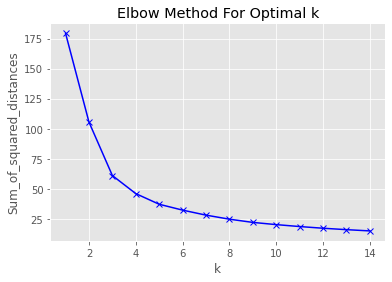

array([ 3,  6,  2, ...,  7, 12,  9])

In [54]:
# Run Elbow for full training data
elbow_plot(principalComponents,maxK=15)

Step 5. Run Kmeans to cluster the embeddings

In [55]:
num_clusters = 2
clf = KMeans(n_clusters=num_clusters, 
            max_iter=100, 
            init='k-means++', 
            n_init=1)
clf.fit_predict(cluster_embeddings)
cluster_assignment = clf.labels_

cdf=pd.DataFrame(columns=["cluster_id","sentence_id","sentence"])

for i in range(len(cluster_assignment)):
    new_row=pd.Series(data={"cluster_id":cluster_assignment[i],
                                "sentence_id":i,
                                "sentence":df_cluster.iloc[i]['original_text'],
                                "label":df_cluster.iloc[i]['label'],
                                "err":str(df_cluster.iloc[i]['err'])
                           }
                            )
    cdf=cdf.append(new_row,ignore_index=True)

cdf.head()

cluster_id sentence_id                                           sentence  \
0          1           0  A mutant is a biological entity which has unde...   
1          0           1                               Love Theme From Kiss   
2          1           2  Sibiu -LRB- ; -RRB- is a county -LRB- jude -RR...   
3          1           3  In the Muromachi era , Buddhist monks discover...   
4          1           4       In the Maya language , Tizimín means tapir .   

  err  label  
0   0    1.0  
1   0    0.0  
2   0    1.0  
3   0    1.0  
4   0    0.0

In [56]:
# Combine PCA results with K-means results to see clustering
df_k=df_pca.merge(cdf,right_on=['sentence_id'],left_on=['sentence_id'])

In [57]:
df_k

principal component 1  principal component 2 sentence_id cluster_id  \
0                 -0.103677               0.265080           0          1   
1                  0.079049               0.157385           1          0   
2                 -0.210159              -0.241884           2          1   
3                 -0.029363               0.205912           3          1   
4                 -0.115050               0.086734           4          1   
...                     ...                    ...         ...        ...   
3787              -0.378418              -0.308927        3787          1   
3788              -0.112015              -0.016098        3788          1   
3789               0.000674              -0.046552        3789          0   
3790              -0.235393              -0.152526        3790          1   
3791               0.102356              -0.016085        3791          0   

                                               sentence err  label  
0     A mutant is a biological entity which has unde...   0    1.0  
1                                  Love Theme From Kiss   0    0.0  
2     Sibiu -LRB- ; -RRB- is a county -LRB- jude -RR...   0    1.0  
3     In the Muromachi era , Buddhist monks discover...   0    1.0  
4          In the Maya language , Tizimín means tapir .   0    0.0  
...                                                 ...  ..    ...  
3787  It is found in the region Aquitaine in the Gir...   0    0.0  
3788  Span -LRB- architecture -RRB- , a section betw...   0    1.0  
3789  Carême gained fame in Paris for his cake centr...   1    0.0  
3790  ThÃ lus is a commune . It is found in the regi...   0    0.0  
3791    Her name translates as '' The Powerful One . ''   0    0.0  

[3792 rows x 7 columns]

Step 6. Plot clustering results

In [108]:
import altair as alt

alt.Chart(df_k).mark_point(size=60,filled=True,stroke='black').encode(
    x='principal component 1',
    y='principal component 2',
    #shape='err',
    shape=alt.Shape('cluster_id:N', scale=alt.Scale(range=['triangle-right', 'circle'])),
    color=alt.Color('err:N',scale=alt.Scale(range=['yellow','red'])),
    #color=alt.Color('cluster_id', scale=alt.Scale(scheme='category20c')),
    tooltip=['sentence','sentence_id','label']
).properties(title='PCA & Kmeans',height=400,width=500).interactive()

alt.Chart(...)

Using UMAP & HDBSCAN  

In [59]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=30, 
                            n_components=2, 
                            metric='cosine').fit_transform(cluster_embeddings)

In [60]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=2,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

In [61]:
umap_embeddings

array([[ 8.679734 ,  9.334293 ],
       [12.985353 , 10.818883 ],
       [ 6.4797134, 13.016064 ],
       ...,
       [10.56392  , 11.994329 ],
       [ 5.676997 , 13.478347 ],
       [10.351501 , 11.287787 ]], dtype=float32)

In [62]:
df_uh = pd.DataFrame(data = umap_embeddings
             , columns = ['UMAP component 1', 'UMAP component 2'])

df_uh['sentence_id']=df_cluster.index

In [63]:
uh_cluster_assignment = cluster.labels_

uh_cdf=pd.DataFrame(columns=["cluster_id","sentence_id","sentence"])

for i in range(len(uh_cluster_assignment)):
    new_row=pd.Series(data={"cluster_id":uh_cluster_assignment[i],
                                "sentence_id":i,
                                "sentence":df_cluster.iloc[i]['original_text'],
                                "label":df_cluster.iloc[i]['label'],
                                "err":str(df_cluster.iloc[i]['err'])
                           }
                            )
    uh_cdf=uh_cdf.append(new_row,ignore_index=True)

uh_cdf.head()

cluster_id sentence_id                                           sentence  \
0        224           0  A mutant is a biological entity which has unde...   
1        198           1                               Love Theme From Kiss   
2          1           2  Sibiu -LRB- ; -RRB- is a county -LRB- jude -RR...   
3        254           3  In the Muromachi era , Buddhist monks discover...   
4        342           4       In the Maya language , Tizimín means tapir .   

  err  label  
0   0    1.0  
1   0    0.0  
2   0    1.0  
3   0    1.0  
4   0    0.0

In [64]:
# Combine PCA results with K-means results to see clustering
df_uh_c=df_uh.merge(uh_cdf,right_on=['sentence_id'],left_on=['sentence_id'])

In [65]:
alt.Chart(df_uh_c).mark_point(size=60).encode(
    x='UMAP component 1',
    y='UMAP component 2',
    shape='err:N',
    color=alt.Color('cluster_id', scale=alt.Scale(scheme='category20c')),
    tooltip=['sentence','label']
).properties(title='UMAP & HBDSCAN',height=400,width=500).interactive()

alt.Chart(...)

In [66]:
df_uh_c[df_uh_c['sentence_id']==4257]

Empty DataFrame
Columns: [UMAP component 1, UMAP component 2, sentence_id, cluster_id, sentence, err, label]
Index: []